[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/0xInode/AI-study-notes/blob/main/ml/hands-on-ml/chapter07/chapter07.ipynb)


# Ensemble Learning and Random Forests

집단지성과 유사하게 여러 예측기(분류기나 회귀기 등)의 예측을 집계하면  
개별 예측기 중 가장 성능이 좋은 것보다 더 나은 예측을 얻을 수 있음  
> 이러한 예측기의 그룹 -> **앙상블(Ensemble)**  
이를 사용하는 기법 -> 앙상블 학습(Ensemble Learning)  
앙상블 학습 알고리즘 -> **앙상블 방법(Ensemble method)**

예를 들어, 여러 개의 결정 트리 분류기를  
훈련 세트에서 무작위로 선택한 서로 다른 하위 집합에 대해 학습시킨 뒤  
각 트리의 예측을 모아 다수결로 최종 클래스를 예측할 수 있음  
이러한 결정 트리 앙상블을 **랜덤 포레스트(Random Forest)**라고 하며  
구현이 간단함에도 불구하고 매우 강력한 머신러닝 알고리즘 중 하나  

앙상블 방법은 보통 프로젝트 후반에 사용  
이미 몇 개의 좋은 예측기를 만들어 둔 뒤 이들을 결합해 더 나은 예측기를 생성할 때 사용  
실제로 머신러닝 대회에서의 우승 솔루션은  
여러 앙상블 방법을 조합해 사용하는 경우가 많음  
(대표적으로 Netflix Prize 대회)  

가장 널리 사용되는 앙상블 방법
- 배깅(Bagging)(+ 랜덤 포레스트)
- 부스팅(Boosting)
- 스태킹(Stacking)


## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifiers

여러 분류기를 훈련시켰다고 가정  
각 분류기는 약 80%의 정확도  
(로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등)

**간단한 방법: 하드 보팅 분류기**  
더 나은 분류기를 만드는 아주 간단한 방법 중 하나: 각 분류기의 예측을 집계하고, 가장 많은 표를 얻은 클래스를 예측하는 것  
이러한 다수결 기반의 분류기 -> 하드 보팅 분류기

이 보팅 분류기는 종종 앙상블 내에서 가장 좋은 분류기보다 더 높은 정확도를 보이는 경우가 있음  
각 분류기가 약한 학습자(무작위 추측보다 약간 더 나은 수준)라고 하더라도  
이들이 충분히 많고 서로 다양하다면  
앙상블 전체는 강한 학습자(높은 정확도)를 이룰 수 있음

왜 이런 일이 가능한가?
앞면이 나올 확률이 51%, 뒷면이 나올 확률이 49%인 동전을 1,000번 던진다고 가정  
보통은 약 510번 앞면, 490번 뒷면이 나와서 결국 앞면이 다수임  
수학적으로 계산해 보면, 1,000번 던졌을 때 앞면이 과반수 이상 나올 확률은 약 75%에 달함  
던지는 횟수를 늘리면 확률은 더 올라감(예: 10,000번이면 97% 이상)  
이것이 바로 대수의 법칙 때문  
반복 횟수가 많아질수록 실제 비율은 이론적 확률에 가까워짐  





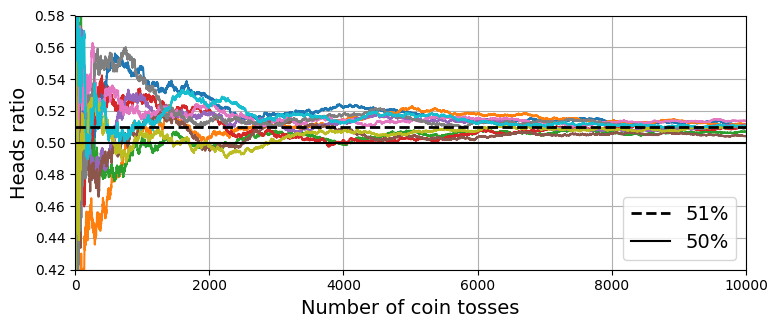

In [5]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)

# 10개의 동전을 10000번 던졌다고 가정해 앞면 여부를 0 또는 1로 생성
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# 누적 앞면 횟수 계산
cumulative_heads = coin_tosses.cumsum(axis=0)

# 누적 앞면 비율 계산
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))

# 동전 던지기 결과의 누적 앞면 비율 시각화
plt.plot(cumulative_heads_ratio)

# 이론적 확률 51%와 50% 기준선 표시
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")

plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()

# 대수의 법칙을 보여주는 그래프 저장
save_fig("law_of_large_numbers_plot")

plt.show()


이와 비슷하게 1,000개의 분류기로 이루어진 앙상블을 만든다고 가정  
각 분류기는 정확도가 51%임  
그러나 다수결로 예측하면, 정확도가 75%까지 올라갈 수 있음  
단, 모든 분류기가 **서로 완전히 독립적일 때만** 가능  
실제로는 동일한 데이터를 학습하기 때문에 비슷한 오류를 범할 가능성이 높고  잘못된 예측으로 다수결이 나올 수도 있음  
이런 경우 앙상블의 정확도는 떨어짐  

**핵심: 다양한 분류기**
앙상블 기법은 개별 모델들이 서로 독립적일수록 더 잘 작동함  
다양한 알고리즘을 사용해 분류기를 훈련시키면 서로 다른 종류의 오류를 범하게 되고, 앙상블의 정확도가 높아짐  

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 반달 모양의 이진 분류 데이터셋 생성 (노이즈 포함)
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 세 가지 서로 다른 모델로 구성된 보팅 분류기 정의
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

# 보팅 분류기 학습
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
# 테스트 데이터 중 첫 번째 샘플에 대한 예측 수행
voting_clf.predict(X_test[:1])


array([1])

In [8]:
# 보팅에 참여한 개별 분류기들이 첫 번째 테스트 샘플에 대해 예측한 클래스 확인
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]


[array([1]), array([1]), array([0])]

In [9]:
# 보팅 분류기의 전체 테스트 세트에 대한 정확도 계산
voting_clf.score(X_test, y_test)


0.912

**소프트 보팅**  
모든 분류기가 클래스 확률을 추정할 수 있다면, 각 클래스의 평균 확률을 계산해 가장 높은 확률의 클래스를 예측하도록 설정 가능  
이를 소프트 보팅이라 하며 하드 보팅보다 성능이 더 좋을 때가 많음  
소프트 보팅을 사용하려면 voting="soft"로 바꾸고, 모든 분류기가 predict_proba() 메서드를 지원해야 함  
SVC는 기본적으로 확률 추정을 지원하지 않으므로 probability=True로 설정 필요  
이 설정을 반영해 소프트 보팅을 적용하면, 정확도가 91.2% 이상으로 상승  

In [10]:
# 소프트 보팅으로 설정 (각 모델의 클래스 확률 평균 사용)
voting_clf.voting = "soft"

# SVC가 클래스 확률을 예측할 수 있도록 설정 (기본값은 비활성화)
voting_clf.named_estimators["svc"].probability = True

# 모델 재학습 (SVC 확률 활성화 후 fit)
voting_clf.fit(X_train, y_train)

# 소프트 보팅 기반 분류기의 정확도 평가
voting_clf.score(X_test, y_test)


0.92

## Bagging and Pasting

서로 다른 분류기를 얻는 한 가지 방법: 서로 매우 다른 학습 알고리즘을 사용하는 것
(앞에서 언급)
또 다른 방법은 모든 예측기에 동일한 학습 알고리즘을 사용하되, 학습 데이터를 무작위로 나눈 서로 다른 부분집합에 대해 훈련시키는 것

샘플링이 복원 추출일 경우 -> **배깅(bagging, bootstrap aggregating)**  
샘플링이 비복원 추출일 경우 -> **패스팅(pasting)**

배깅과 패스팅 모두 여러 예측기에 대해 학습 샘플을 여러 번 선택 가능  
동일한 예측기에 대해 중복 샘플이 허용되는 건 배깅뿐(복원추출이라)

예측기들이 모두 훈련된 후 앙상블은 새 샘플에 대해 모든 예측 결과를 집계하여 예측
분류의 경우 보통 **최빈값(가장 많이 나온 클래스)** 사용  
회귀의 경우 평균값 사용

개별 예측기는 전체 학습 데이터를 쓰지 않기 때문에 편향 높아짐  
하지만 여러 개의 예측 결과를 집계하면 편향과 분산 모두 감소  
결과적으로 앙상블은 단일 모델보다 유사한 수준의 편향을 가지면서도 더 낮은 분산을 얻게 됨

각 예측기는 서로 다른 CPU 코어나 서버에서 병렬로 훈련 가능  
예측 수행도 마찬가지로 병렬 처리 가능

이러한 이유로 배깅과 패스팅은 확장성이 매우 좋아 널리 사용됨

### Bagging and Pasting in Scikit-Learn

Scikit-Learn은 BaggingClassifier 클래스(BaggingRegressor는 회귀용)를 통해 배깅과 페이팅 모두에 대해 간단한 API 제공  

아래 코드는 500개의 결정 트리 분류기로 구성된 앙상블을 학습  
각 트리는 훈련 세트에서 중복을 허용하여 무작위로 추출한 100개의 샘플을 기반으로 학습됨(배깅)  
페이팅을 사용하려면 bootstrap=False로 설정  
n_jobs 매개변수는 학습과 예측에 사용할 CPU 코어 수를 지정(-1: 사용 가능한 모든 코어 사용)


In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 기반 배깅 분류기 (500개 트리, 샘플 100개씩, 병렬 처리)
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)

# 모델 학습
bag_clf.fit(X_train, y_train)


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

BaggingClassifier는 기본 분류기가 클래스 확률을 추정할 수 있는 경우(predict_proba() 메서드를 가지고 있는 경우)  
하드 보팅 대신 소프트 보팅을 자동으로 수행   
결정 트리 분류기의 경우 이에 해당  
(DecisionTreeClassifier 등은 predict_proba() 메서드를 제공 -> 클래스 확률 추정 가능)

다음 그래프는 moons 데이터셋에 대해 학습된 단일 결정 트리와 500개의 트리로 구성된 배깅 앙상블의 결정 경계 비교  
앙상블의 예측은 단일 결정 트리보다 일반화 성능이 더 우수할 가능성이 높음    
앙상블은 유사한 편향을 가지면서도 분산이 더 작음  
(훈련 세트에서의 오류 수는 비슷하지만 결정 경계가 덜 불규칙)

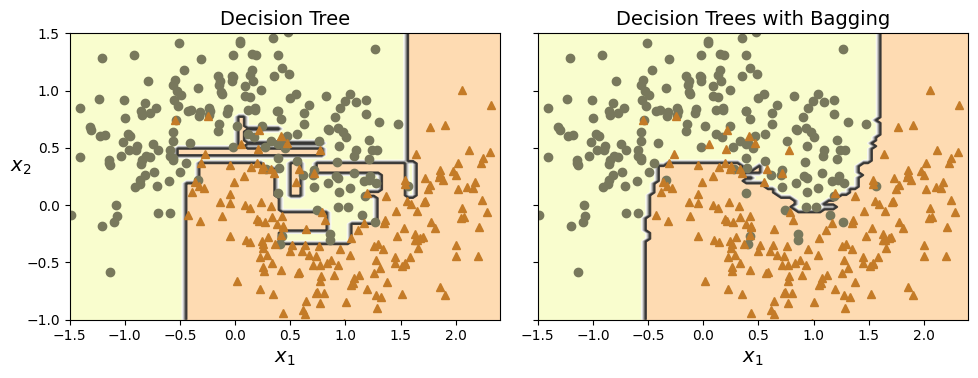

In [12]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    # 결정 경계 시각화를 위한 그리드 생성
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # 예측 결과를 배경 색으로 표시
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)

    # 클래스별 데이터 포인트 시각화
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

# 단일 결정 트리 훈련
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# 단일 트리 vs 배깅 결과 시각화
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")

# 그래프 저장 및 출력
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()


부트스트래핑은 각 예측기가 학습하는 데이터 부분집합에 약간 더 다양한 요소 추가  
-> 배깅은 페이팅보다 약간 더 높은 편향 가짐

하지만 이러한 다양성 덕분에 예측기들 간의 상관성이 낮아져 앙상블 분산 감소  
결과적으로 배깅은 더 나은 모델을 생성하는 경우가 많아 일반적으로 더 선호됨  
하지만 여유 시간과 CPU 자원이 있다면 교차 검증을 사용해 배깅과 페이팅을 모두 평가하고 더 잘 작동하는 방식을 선택하는 것도 가능  


### Out-of-Bag Evaluation

배깅을 사용할 경우 어떤 예측기는 특정 샘플을 여러 번 사용하고 어떤 샘플은 전혀 사용하지 않을 수 있음  
기본적으로 BaggingClassifier는 훈련 세트 크기만큼의 샘플을 중복 허용하여 추출(bootstrap=True)  
-> 각 예측기당 평균적으로 전체 훈련 샘플의 약 63%만 사용됨  
선택되지 않은 나머지 약 37%의 샘플: **oob(out-of-bag) 인스턴스**  
이 37%는 모든 예측기에 대해 동일한 샘플 X

>※ 63%의 샘플이 선택되는 이유  
>데이터셋의 크기가 m일 때 임의로 하나의 샘플을 뽑을 경우  
각 샘플이 선택될 확률: 1/m  
어떤 샘플이 선택되지 않을 확률: 1 – 1/m  
>이제 중복을 허용해 m번 샘플을 뽑는다면  
각 추출은 독립적이므로  
어떤 샘플이 한 번도 선택되지 않을 확률: (1 – 1/m)^m  
>여기서 지수 함수의 성질인  
exp(x) = lim (1 + x/m)^m (m → ∞) 사용  
m이 클 경우 (1 – 1/m)^m ≈ exp(–1) ≈ 0.37  
약 37%의 샘플이 선택되지 않고 oob 인스턴스가 되며,  
반대로 약 63%의 샘플이 선택되어 각 예측기의 학습에 사용됨

예측기는 학습 과정에서 oob 인스턴스를 보지 않기 때문에  
별도의 검증 세트 없이도 해당 인스턴스에 대해 평가 가능(oob 인스턴스를 마치 테스트 데이터처럼 사용)  
전체 앙상블은 각 예측기의 oob 평가 결과를 평균내어 성능을 추정할 수 있음

Scikit-Learn에서는 `BaggingClassifier` 생성 시 `oob_score=True`로 설정하면 학습 후 자동으로 oob 평가가 수행  
평가 결과는 `oob_score_` 변수에 저장  

In [13]:
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)  # 500개의 결정 트리로 배깅 앙상블 생성 및 oob 평가 활성화
bag_clf.fit(X_train, y_train)  # 훈련 데이터로 앙상블 학습
bag_clf.oob_score_  # oob 인스턴스를 활용한 자동 평가 결과 확인


0.896

In [15]:
bag_clf.oob_decision_function_[:3]  # 처음 3개 샘플에 대한 oob 기반 클래스 확률 예측값



array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)  # 테스트 세트에 대한 앙상블 예측 수행
accuracy_score(y_test, y_pred)  # 테스트 세트 기준 정확도 평가


0.92

테스트 세트에서 92%의 정확도를 얻었으며 충분히 만족할 만한 수준  
각 훈련 샘플에 대한 oob 결정 함수 값은 `oob_decision_function_` 변수로 확인 가능

이 경우(기본 추정기가 predict_proba() 메서드를 가지고 있으므로)   
결정 함수는 각 훈련 샘플에 대한 클래스 확률을 반환  
oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률이 68.25%,  
음성 클래스일 확률이 31.75%라고 추정

## Random Patches and Random Subspaces

BaggingClassifier 클래스는 특성 샘플링도 지원  
-> `max_features`와 `bootstrap_features` 두 하이퍼파라미터로 제어  
`max_samples`와 `bootstrap`과 유사하게 작동하지만,   
샘플이 아닌 **입력 특성(feature)**에 적용  
=> 각 예측기는 입력 특성의 무작위 부분집합만을 사용해 학습됨

이 기법은 특히 이미지처럼 차원이 높은 입력을 다룰 때 유용

- Random Patches 방법:
훈련 샘플과 특성 모두를 무작위로 샘플링하는 방식

- Random Subspaces 방법:
훈련 샘플은 모두 유지(bootstrap=False, max_samples=1.0)하면서
특성만 무작위로 샘플링(bootstrap_features=True 또는 max_features < 1.0)하는 방식

특성을 샘플링하면 예측기 간 다양성이 더욱 증가  
이는 약간의 편향 증가와 맞바꾸는 대신 분산을 더 줄일 수 있게 해 줌

## Random Forests

랜덤 포레스트는 결정 트리들의 앙상블이며   
일반적으로 배깅 방식(또는 때로는 페이팅)을 통해 학습  
`max_samples`는 훈련 세트 크기로 설정

`BaggingClassifier`에 `DecisionTreeClassifier`를 넘겨서 구성할 수도 있지만,  
대신 `RandomForestClassifie` 클래스를 사용하는 것이 더 편리하고 결정 트리에 최적화  
(회귀용으로는 `RandomForestRegressor` 클래스)


In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)  # 500개의 트리로 구성된 랜덤 포레스트 생성(각 트리 최대 16개 노드로 제한)
rnd_clf.fit(X_train, y_train)  # 훈련 데이터로 랜덤 포레스트 학습
y_pred_rf = rnd_clf.predict(X_test)  # 테스트 세트에 대한 예측 수행


몇몇 예외를 제외하면 `RandomForestClassifier`는  
트리 생성 방식을 제어하는 `DecisionTreeClassifier`의 하이퍼파라미터와  
앙상블 전체를 제어하는 `BaggingClassifier`의 하이퍼파라미터를 모두 가짐

랜덤 포레스트 알고리즘은 트리를 성장시킬 때 **추가적인 무작위성 도입**  
노드를 분할  최적의 특성을 전체 특성 중에서 찾는 대신(일반적 결정 트리),  
무작위로 선택한 특성의 부분집합 중에서 최적의 특성을 찾음  

이 방식은 트리 간 다양성 증가
- 약간의 편향 ↑(개별 트리의 성능 약간 낮아짐)
- 분산 ↓ (과적합 방지)  
=> 전반적으로 더 나은 모델 생성  


In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)  # 무작위 특성 선택과 노드 수 제한을 적용한 결정 트리 500개로 구성된 배깅 앙상블 생성


In [19]:
bag_clf.fit(X_train, y_train)  # 배깅 앙상블 학습 수행
y_pred_bag = bag_clf.predict(X_test)  # 테스트 세트에 대한 예측 수행
np.all(y_pred_bag == y_pred_rf)  # 랜덤 포레스트와 예측 결과가 동일한지 확인


np.True_

### Extra-Trees

랜덤 포레스트에서는 각 노드에서 분할을 위해 무작위로 선택된 일부 특성만 고려
Extra-Trees는 각 특성에 대해 최적 분할 기준을 찾는 대신 무작위 임계값 사용


> 랜덤 포레스트: 무작위 특성 + 최적 임계값  
엑스트라 트리: 무작위 특성 + 무작위 임계값


이렇게 만들어진 매우 무작위적인 트리의 앙상블:  
**Extremely Randomized Trees(Extra-Trees)**

더 높은 편향을 감수  
분산을 더 낮추고  
무작위 임계값 덕분에 학습 속도도 더 빠름  
(각 노드에서 최적 분할 기준을 찾는 과정이 트리 학습에서 가장 느린 작업 중 하나)

Scikit-Learn에서는 `ExtraTreesClassifier` 클래스를 사용해 `Extra-Trees` 분류기를 생성할 수 있으며 API는 `RandomForestClassifier`와 동일  
회귀용: `ExtraTreesRegressor` 클래스, 역시 `RandomForestRegressor`와 같은 API

어떤 경우에 `RandomForestClassifier`가 `ExtraTreesClassifier`보다 성능이 더 좋을지는 미리 알기 어려움  
교차 검증을 통해 둘 다 실험해 보고,  
그리드 서치 등으로 하이퍼파라미터 튜닝 후 비교하는 것이 유일한 방법

### Feature Importance

랜덤 포레스트의 또 다른 강점은   
**각 특성의 상대적 중요도를 쉽게 측정할 수 있다**는 점  

Scikit-Learn은 트리의 노드에서 **해당 특성이 평균적으로 얼마나 불순도를 감소시켰는지 기준**으로 중요도 계산  
이 값은 모든 트리에 걸쳐 **가중 평균으로 집계**되며,  
여기서 각 노드의 가중치는 그 노드에 해당하는 훈련 샘플 수(6장에서 설명됨)

학습이 끝난 후 Scikit-Learn은 각 특성에 대해 이 점수를 자동으로 계산  
그다음 결과를 정규화해 전체 중요도의 합이 1이 되도록 조정(직관적 비교 위해)  
중요도 결과는 `feature_importances_` 변수로 확인 가능

아래 코드는 iris 데이터셋에 대해 RandomForestClassifier를 학습시키고
각 특성의 중요도를 출력  
결과적으로 꽃잎 길이(44%)와 너비(42%)가 가장 중요하며  
꽃받침 길이(11%)와 너비(2%)는 상대적으로 중요하지 않음

In [20]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)  # iris 데이터셋으로 랜덤 포레스트 학습

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)  # 각 특성의 중요도를 소수 둘째 자리까지 출력


0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


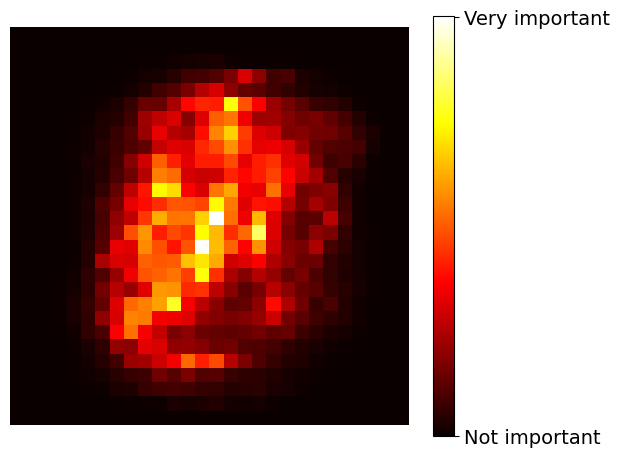

In [21]:
from sklearn.datasets import fetch_openml  # MNIST 데이터셋

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')  # 특성과 레이블을 각각 변수로 저장

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)  # 랜덤 포레스트 모델 생성
rnd_clf.fit(X_mnist, y_mnist)  # 모델을 MNIST 데이터로 학습

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)  # 각 픽셀의 중요도를 28x28로 재구성
plt.imshow(heatmap_image, cmap="hot")  # 중요도 히트맵 시각화
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])  # 컬러바 추가
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)  # 컬러바 눈금 라벨 설정
plt.axis("off")  # 축 제거
save_fig("mnist_feature_importance_plot")
plt.show()


랜덤 포레스트는 어떤 특성이 실제로 중요한지를 빠르게 파악하는 데 매우 유용  
특히 특성 선택이 필요한 경우에 효과적

## Boosting

부스팅(원래는 가설 부스팅hypothesis boosting이라 불림)은 여러 약한 학습기를 결합해 강한 학습기를 만드는 앙상블 기법 의미  
대부분의 부스팅 방법은 예측기를 순차적으로 학습, 각 예측기는 이전 예측기의 오류 보완 시도

부스팅 방법은 다양하지만 가장 널리 사용되는 방식은 다음 두 가지
- AdaBoost(Adaptive Boosting의 약어)
- 그래디언트 부스팅

### AdaBoost

새 예측기가 이전 예측기의 오류를 보완하는 한 가지 방법:
이전 예측기가 과소적합한 훈련 샘플에 좀 더 집중  

이로 인해 이후 예측기들이 점점 더 어려운 사례에 집중(AdaBoost에서 사용되는 방식)

예를 들어 AdaBoost 분류기를 학습할 때
- 알고리즘은 먼저 기본 분류기(예: 결정 트리)를 하나 학습시킨 뒤
이를 사용해 훈련 세트에 대해 예측 수행
- 그다음 잘못 분류된 훈련 샘플들의 상대적 가중치 증가
- 그 다음 분류기를 학습할 때 이 업데이트된 가중치를 반영해 학습
- 다시 훈련 세트에 대해 예측한 후 가중치 업데이트
- 이 과정 반복

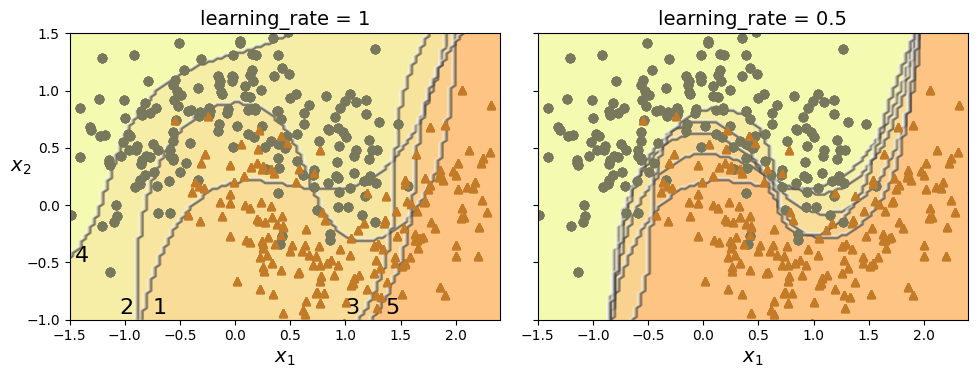

In [22]:
m = len(X_train)  # 훈련 샘플 수 저장

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)  # 두 개의 서브플롯 생성
for subplot, learning_rate in ((0, 1), (1, 0.5)):  # 학습률 1과 0.5에 대해 반복
    sample_weights = np.ones(m) / m  # 모든 샘플에 동일한 초기 가중치 부여
    plt.sca(axes[subplot])  # 현재 subplot 설정
    for i in range(5):  # 5개의 순차적 SVM 학습기 생성
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)  # RBF 커널 SVM 생성
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)  # 가중치를 반영한 모델 학습

        y_pred = svm_clf.predict(X_train)  # 훈련 세트에 대한 예측 수행

        error_weights = sample_weights[y_pred != y_train].sum()  # 오분류 샘플의 가중치 합산
        r = error_weights / sample_weights.sum()  # 오차율 계산 (공식 7-1)
        alpha = learning_rate * np.log((1 - r) / r)  # 학습기 가중치 계산 (공식 7-2)
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # 오분류 샘플 가중치 증가 (공식 7-3)
        sample_weights /= sample_weights.sum()  # 가중치 정규화

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)  # 결정 경계 시각화
        plt.title(f"learning_rate = {learning_rate}")  # 타이틀에 학습률 표시
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)  # 순서 라벨 부여
    else:
        plt.ylabel("")  # 오른쪽 그래프에서 y축 라벨 제거

save_fig("boosting_plot")  # 이미지 파일로 저장
plt.show()  # 시각화 출력


위 그래프는 moons 데이터셋에 대해 연속된 다섯 개의 예측기가 만든 결정 경계    
(이 예에서는 각 예측기가 RBF 커널을 사용하는 강하게 정규화된 SVM 분류기)

첫 번째 분류기는 많은 샘플을 잘못 분류하고, 이 잘못된 샘플들의 가중치가 증가  
두 번째 분류기는 이 샘플들에 더 집중해 더 나은 성능  
이 과정을 반복하며 예측기가 점점 향상

오른쪽 그림은 동일한 예측기 순서이지만 학습률이 절반(0.5)으로 설정된 경우  
-> 잘못 분류된 샘플들의 가중치가 매 반복마다 절반만큼 증가

이와 같은 순차적 학습 방식은 경사 하강법과 유사  
하지만 하나의 예측기 파라미터를 조정해 비용 함수를 최소화하는 대신  
AdaBoost는 **예측기를 하나씩 추가**하며 전체 앙상블을 점진적으로 향상시킴

모든 예측기가 학습된 후 앙상블은 배깅이나 패스팅과 매우 유사한 방식으로 예측 수행  
단, 각 예측기의 가중치는 가중치가 적용된 훈련 세트에서의 전체 정확도에 따라 다르게 설정

이러한 순차적 학습 방식의 단점:
각 예측기가 이전 예측기의 학습과 평가 이후에만 학습될 수 있기 때문에 병렬 처리가 불가능하거나 제한적  
-> 배깅이나 패스팅에 비해 확장성이 떨어짐

[AdaBoost 알고리즘]  
각 샘플 가중치 $𝑤^{(𝑖)}$는 처음에 1/𝑚으로 설정  
첫 번째 예측기를 학습시키고, 가중치가 반영된 오차율 $𝑟_1$을 훈련 세트에 대해 계산

$$
r_j = \frac{\sum_{i=1}^{m} w^{(i)} \cdot \left[ \hat{y}_j^{(i)} \ne y^{(i)} \right]}{\sum_{i=1}^{m} w^{(i)}}
$$

- $\hat{y}_j^{(i)}$: $j$번째 예측기가 $i$번째 샘플에 대해 예측한 값
- $y^{(i)}$: $i$번째 샘플의 실제 정답



$$
\alpha_j = \eta \log \left( \frac{1 - r_j}{r_j} \right)
$$


예측기의 가중치 $𝛼_𝑗$는 다음 공식을 사용해 계산하며  
여기서 $𝜂$는 학습률 하이퍼파라미터로 기본값은 1

예측기가 정확할수록 $𝛼_𝑗$ 값이 커짐  
예측기가 무작위로 추측하는 수준이라면 가중치는 0에 가까움  
반대로 대부분 틀리는 경우(무작위 추측보다 정확도가 낮은 경우)에는 가중치가 음수가 됨

$$
\text{for } i = 1, 2, \cdots, m \quad
w^{(i)} \leftarrow
\begin{cases}
w^{(i)} & \text{if } \hat{y}_j^{(i)} = y^{(i)} \\
w^{(i)} \exp(\alpha_j) & \text{if } \hat{y}_j^{(i)} \ne y^{(i)}
\end{cases}
$$


AdaBoost 알고리즘은 위 공식을 사용해 샘플 가중치 업데이트  
오분류된 샘플의 가중치를 증가시킴

오분류 여부에 따라:

* $ \hat{y}_j^{(i)} = y^{(i)} $ 이면 $ w^{(i)} $ 그대로 유지  
* $ \hat{y}_j^{(i)} \ne y^{(i)} $ 이면 $ w^{(i)} \leftarrow w^{(i)} \cdot \exp(\alpha_j) $


그 후 모든 샘플 가중치를 정규화  
-> $w^{(i)}$를 $\sum_{i=1}^{m} w^{(i)}$로 나눔

그 다음 업데이트된 가중치를 사용해 새로운 예측기를 학습시키고  
같은 과정을 반복(가중치 계산 → 샘플 가중치 갱신 → 새로운 예측기 학습)

이 알고리즘은 설정된 예측기 개수에 도달하거나 완벽한 예측기가 생성되면 종료

예측 시 AdaBoost는 모든 예측기의 예측값을 모아 각 예측기의 가중치
$𝛼_𝑗$를 적용한 후
가중치가 가장 높은 클래스를 최종 예측값으로 선택

$$
\hat{y}(x) = \arg\max_k \sum_{j=1}^{N} \alpha_j \cdot \mathbb{1}\left[ \hat{y}_j(x) = k \right]
$$


Scikit-Learn은 AdaBoost의 다중 클래스 버전인 SAMME(Stagewise Additive Modeling using a Multiclass Exponential loss function) 사용

클래스가 두 개인 경우 SAMME는 일반 AdaBoost와 동일  
예측기가 클래스 확률을 추정할 수 있다면(predict_proba() 메서드 제공 시)  
SAMME의 변형인 `SAMME.R` 사용 가능  
여기서 R은 Real 의미  
예측값 대신 클래스 확률을 사용, 일반적으로 성능 더 우수


※ Scikit-Learn 1.3부터는 `SAMME.R` 지원이 제거됨 -> API 단순화와 예측 일관성 문제 때문  
대안: `GradientBoostingClassifier` 또는 `HistGradientBoostingClassifier` 사용

AdaBoost 앙상블이 훈련 세트에 과적합(overfitting) 시
- 예측기 수(n_estimators) 감소
- 기본 예측기를 더 강하게 정규화 시도

### Gradient Boosting

또 다른 인기 있는 부스팅 알고리즘  
AdaBoost처럼 그래디언트 부스팅도 예측기를 순차적으로 앙상블에 추가  
각 예측기가 이전 예측기의 오류를 보정하는 방식으로 작동  

하지만 AdaBoost는 반복마다 샘플 가중치를 조정하는 반면  
그래디언트 부스팅은 이전 예측기가 만든 오차(잔차)에 새로운 예측기를 맞추려고 시도  
-> 오차 자체를 다음 예측기의 타깃으로 사용하는 방식

간단한 회귀 예제를 통해 살펴보면,  
기본 예측기로는 결정 트리를 사용할 수 있음  
(그래디언트 부스팅은 회귀에도 매우 잘 작동함)

이러한 방식은 Gradient Tree Boosting 또는  
**Gradient Boosted Regression Trees (GBRT)**라고 부름

먼저 결정 트리 회귀 모델(DecisionTreeRegressor)을 훈련 세트에 적합시킴(예: 잡음이 포함된 이차 함수 형태의 훈련 데이터)

In [23]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + 가우시안 잡음 추가된 타깃값 생성

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)  # 깊이 2인 결정 트리 회귀 모델 생성
tree_reg1.fit(X, y)  # 첫 번째 회귀 트리를 데이터에 적합시킴


DecisionTreeRegressor(max_depth=2, random_state=42)

In [24]:
y2 = y - tree_reg1.predict(X)  # 첫 번째 트리의 예측 오차(잔차)를 계산하여 두 번째 트리의 타깃으로 사용
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)  # 두 번째 회귀 트리 생성
tree_reg2.fit(X, y2)  # 잔차에 대해 두 번째 트리 학습


DecisionTreeRegressor(max_depth=2, random_state=43)

In [25]:
y3 = y2 - tree_reg2.predict(X)  # 두 번째 트리의 예측 오차를 계산하여 세 번째 트리의 타깃으로 사용
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)  # 세 번째 회귀 트리 생성
tree_reg3.fit(X, y3)  # 잔차에 대해 세 번째 트리 학습


DecisionTreeRegressor(max_depth=2, random_state=44)

In [26]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))  # 세 트리의 예측값을 단순 합산하여 최종 예측 생성


array([0.49484029, 0.04021166, 0.75026781])

- 왼쪽 열: 각 트리의 개별 예측 결과
- 오른쪽 열: 앙상블 전체의 누적 예측 결과
- 첫 번째 행: 트리 하나만 있을 때 예측은 첫 트리와 동일
- 두 번째 행: 두 번째 트리가 첫 트리의 오차를 보정하며 예측 개선
- 세 번째 행: 세 번째 트리가 남은 오차를 보정하며 예측이 더 정교

-> 트리가 추가될수록 앙상블의 성능이 점진적으로 향상

더 간단한 방법: `GradientBoostingRegressor` 사용  
같은 방식의 모델을 훨씬 간단히 구현

이 클래스는 `RandomForestRegressor`처럼  
- 트리 구조를 제어하는 하이퍼파라미터(`max_depth`, `min_samples_leaf` 등)
- 앙상블 학습을 제어하는 하이퍼파라미터(`n_estimators` 등) 제공

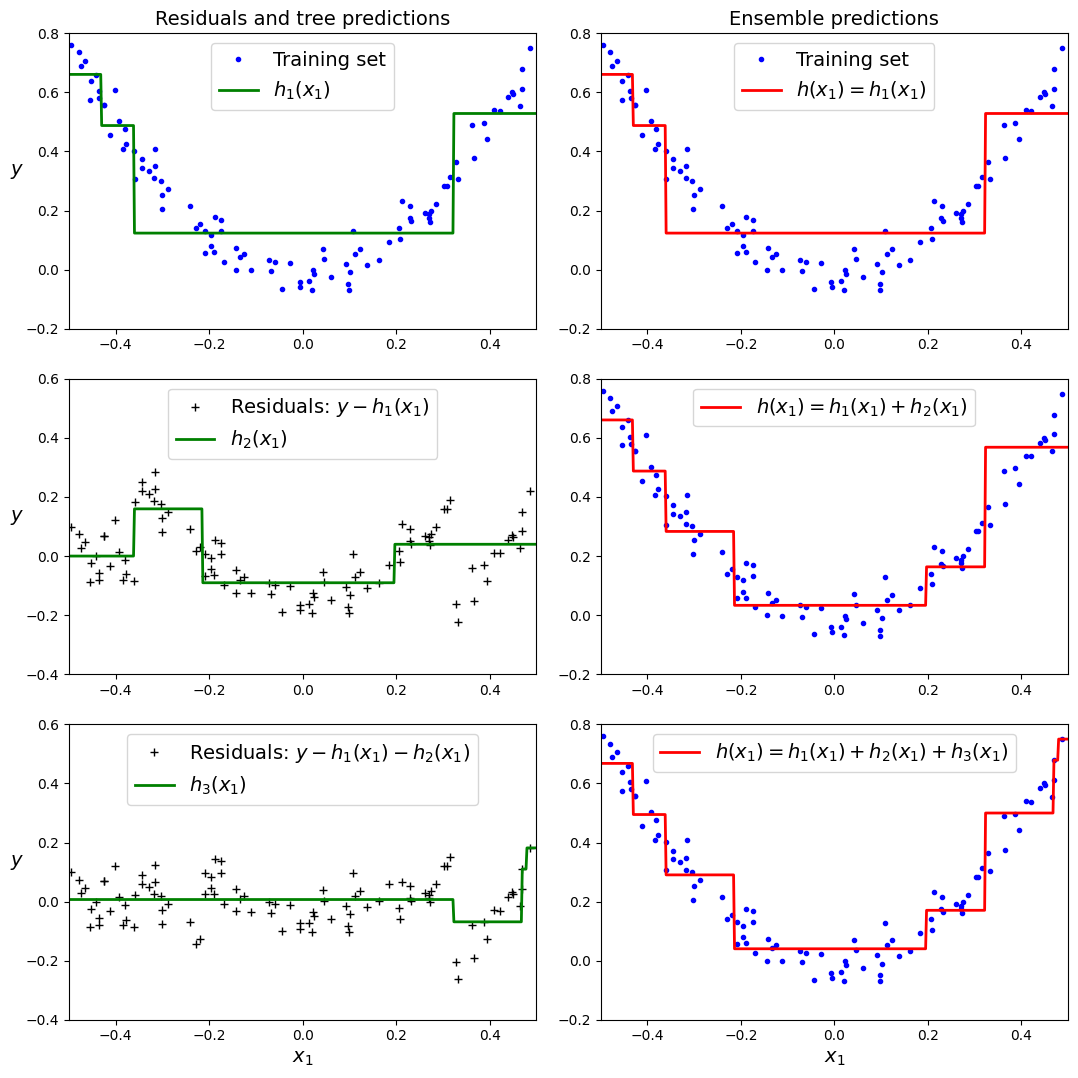

In [27]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)  # 앙상블의 예측값 계산 (개별 트리 예측값 합산)
    plt.plot(X[:, 0], y, data_style, label=data_label)  # 원본 데이터 또는 잔차 시각화
    plt.plot(x1, y_pred, style, linewidth=2, label=label)  # 예측 곡선 시각화
    if label or data_label:
        plt.legend(loc="upper center")  # 범례 추가
    plt.axis(axes)  # 축 범위 설정

plt.figure(figsize=(11, 11))  # 전체 도표 크기 설정

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")  # 첫 번째 트리 예측 시각화
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")  # 앙상블=트리1일 때 예측
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")  # 두 번째 트리의 잔차 예측 시각화
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")  # 트리1 + 트리2 앙상블 예측

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")  # 세 번째 트리의 잔차 예측 시각화
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")  # 전체 앙상블 예측
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")  # 이미지 저장
plt.show()  # 전체 플롯 출력


위 그래프는 그래디언트 부스팅의 작동 방식을 보여줌
왼쪽 열은 각각의 예측기
첫 번째 예측기(좌상단)는 일반적인 방식으로 학습
그 다음 예측기들(중간과 하단 왼쪽)은 이전 예측기의 **잔차(residuals)**를 학습
오른쪽 열은 해당 시점까지의 앙상블 예측 결과

**학습률 (learning_rate) 하이퍼파라미터**: 각 트리의 기여도 조절
>값이 작을수록(예: 0.1) 더 많은 트리가 필요하지만
일반화 성능이 더 좋음

-> **수축(shrinkage)**이라고 하는 정규화 기법 중 하나






In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)  # 세 개의 깊이 2인 트리를 사용하는 그래디언트 부스팅 회귀 모델 생성
gbrt.fit(X, y)  # 모델 학습


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [29]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)  # 조기 종료 조건이 포함된 그래디언트 부스팅 회귀 모델 생성 (10번 연속 개선 없으면 중단)
gbrt_best.fit(X, y)  # 모델 학습



GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [30]:
gbrt_best.n_estimators_  # 실제로 학습에 사용된 트리 개수 확인 (조기 종료가 적용된 경우 500보다 작을 수 있음)


92

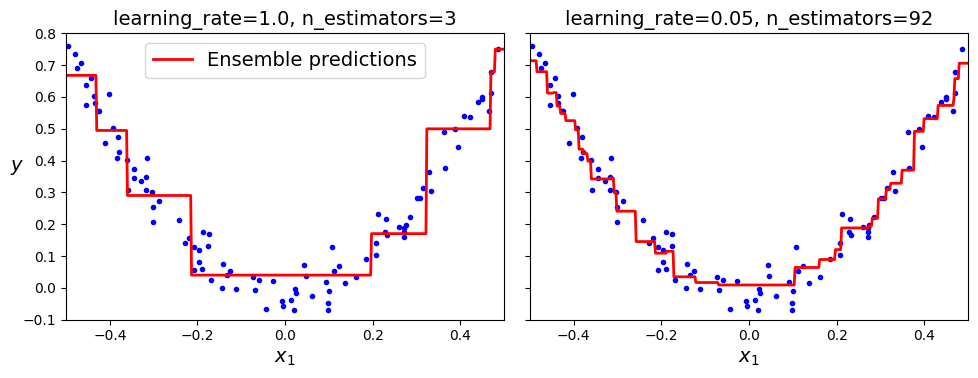

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)  # 두 개의 서브플롯 생성

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")  # 기본 학습률(1.0)로 학습한 모델 시각화
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")  # 작은 학습률과 조기 종료가 적용된 모델 시각화
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")  # 결과 이미지 저장
plt.show()  # 시각화 출력


위 그래프는 학습률이 낮은 GBRT 모델 두 개:
- 왼쪽: 트리 수가 부족 → 훈련 세트에 과소적합
- 오른쪽: 트리 수가 너무 많음 → 훈련 세트에 과적합

최적 트리 개수 찾기: **조기 종료 (early stopping)**(챕터 4 참고)  
간단한 구현 방법: `staged_predict()` 메서드 사용  
→ 학습 중 매 단계(트리 1개, 2개, …)마다의 예측값을 이터레이터 형태로 반환

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y)

# 트리 120개로 그래디언트 부스팅 모델 학습
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

# 각 단계별 예측값에 대한 검증 오차 계산
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# 오차가 최소가 되는 트리 개수 결정 (인덱스가 0부터 시작하므로 +1)
bst_n_estimators = np.argmin(errors) + 1

# 최적 트리 수로 새로운 모델 학습
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(80))

이 방식은 검증 오차가 최소가 되는 시점에서 학습을 멈추는 방식의 조기 종료 전략  
불필요한 트리를 피하고 과적합 위험 감소 효과

학습을 모두 마친 뒤 최적 트리 수를 고르는 방식 대신  
학습 도중에 실제로 중단하는 방식의 조기 종료도 구현 가능

이를 위해 `warm_start=True`를 설정하면  
Scikit-Learn은 `fit()` 호출 시 기존 트리를 유지하며 점진적으로 학습 가능


In [33]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)  # 트리를 누적하며 학습할 수 있도록 설정
min_val_error = float("inf")  # 검증 오차의 초기값을 무한대로 설정
error_going_up = 0  # 연속으로 오차가 증가한 횟수 카운트

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators  # 현재 트리 개수 설정
    gbrt.fit(X_train, y_train)  # 기존 트리를 유지하며 학습 계속
    y_pred = gbrt.predict(X_val)  # 검증 세트에 대한 예측 수행
    val_error = mean_squared_error(y_val, y_pred)  # 검증 오차 계산

    if val_error < min_val_error:
        min_val_error = val_error  # 더 낮은 오차를 발견하면 업데이트
        error_going_up = 0  # 오차가 감소했으므로 카운트 초기화
    else:
        error_going_up += 1  # 오차가 증가했으므로 카운트 증가

    if error_going_up == 5:
        break  # 5번 연속으로 오차가 개선되지 않으면 조기 종료


`GradientBoostingRegressor`는 `subsample` 하이퍼파라미터도 지원  
이는 각 트리를 학습할 때 훈련 샘플의 일부만 무작위로 선택해 사용하는 비율  
> 예: subsample=0.25이면 각 트리는 전체 훈련 샘플 중 25%만 사용

이 기법은 바이어스를 증가시키는 대신 분산을 줄이고 학습 속도를 크게 높임  
-> **확률적 그래디언트 부스팅 (Stochastic Gradient Boosting)**

그래디언트 부스팅은 다른 손실 함수들과 함께 사용할 수 있음  
이 기능은 `loss` 하이퍼파라미터로 제어

XGBoost(Extreme Gradient Boosting): 그래디언트 부스팅의 고성능 구현체

**Distributed (Deep) Machine Learning Community (DMLC)**의 일환으로 개발
- 매우 빠르고
- 확장 가능
- 이식성 뛰어남

XGBoost의 API는 Scikit-Learn과 매우 유사

In [44]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()

# eval_set 등 인자 포함한 학습
xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=2
)

# 예측
y_pred = xgb_reg.predict(X_val)


TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

## Stacking

**스태킹**(**Stacking**, stacked generalization)

기본 아이디어는 단순함:
앙상블의 개별 예측기 결과를 단순한 방식(예: 하드 보팅)으로 결합하는 대신,
이 결합을 수행하는 모델을 따로 학습시키는 것

아래 그림은 새로운 샘플에 대해 회귀 작업을 수행하는 스태킹 앙상블:  
아래쪽에 있는 세 개의 예측기가 각각 다른 값을 예측함 (3.1, 2.7, 2.9)  
그 위에 있는 최종 예측기(블렌더 또는 메타 학습기)가  
이 예측값들을 입력으로 받아 최종 예측값인 3.0을 출력

=> 스태킹은 예측기의 예측을 다시 예측하는 구조



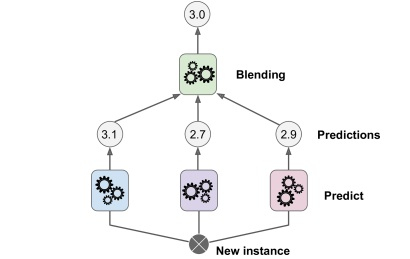
[7-12. 블렌딩 예측기를 사용한 예측 결합]

블렌더(blender)를 학습시키기 위해 일반적으로 사용하는 방법: **홀드아웃 세트(hold-out set)** 활용

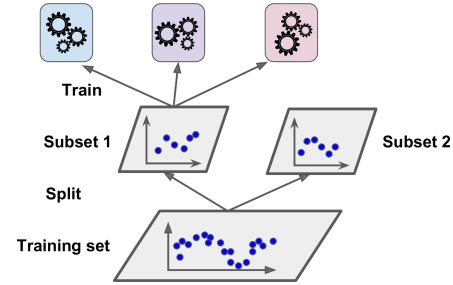
[7-13. 첫 번째 층 학습]

첫 번째 층의 예측기를 사용해 두 번째(홀드아웃) 세트(그림 7-14)에 대해 예측 수행
이렇게 하면 예측값이 **깨끗한(clean)** 상태가 되는데,  
이는 예측기들이 학습 중 해당 샘플을 본 적이 없기 때문

각 홀드아웃 샘플마다 예측값이 세 개 생김  
이 예측값들을 입력 특성으로 사용하여 새로운 훈련 세트를 만들 수 있으며(이 새 훈련 세트는 3차원 형태가 됨)  
타깃 값은 그대로 유지  
블렌더는 이 새로운 훈련 세트에 대해 학습되어  
첫 번째 층의 예측값을 기반으로 타깃 값을 예측하는 방법 학습

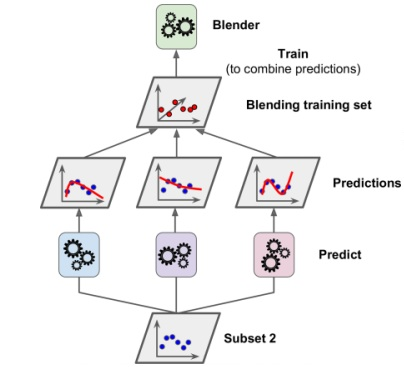
[7-14. 블렌더 학습]

같은 방식으로 여러 종류의 블렌더(예: 선형 회귀, 랜덤 포레스트 회귀)를 학습시켜
블렌더 하나의 층을 구성할 수도 있음

이때 요령은 훈련 세트를 세 개의 하위 세트로 나누는 것
- 첫 번째 세트는 첫 번째 층 학습에 사용
- 두 번째 세트는 첫 번째 층의 예측값을 사용하여 두 번째 층 학습용 훈련 세트를 만드는데 사용
- 세 번째 세트는 두 번째 층의 예측값을 사용하여 세 번째 층 학습용 훈련 세트를 만드는데 사용

이 과정을 마치면 새로운 샘플에 대해 예측할 때
각 층을 순차적으로 통과시키며 예측할 수 있음(7-15 참조)

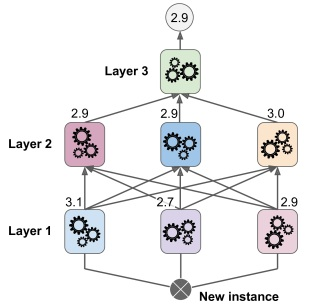
[7-15. 다층 스태킹 앙상블의 예측]

Scikit-Learn은 스태킹을 직접적으로 지원하지 않지만  
직접 구현하는 것도 어렵지 않음  
DESlib과 같은 오픈소스 구현체를 사용할 수도 있음